In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv("../data/bike_clean_rep_std.csv")
df.head()

,Unnamed: 0,date,season,holiday,snowfall,rainfall,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rep_count,rep_count_smooth
0,1,2017-12-01,Winter,No Holiday,-0.207935,-0.301217,-0.718560,-1.210691,-1.290740,-0.366447,0.950591,-1.643317,-0.701162,732,732.0000
1,2,2017-12-02,Winter,No Holiday,-0.207935,-0.301217,-0.817599,-0.877656,-0.161708,-0.066047,-0.052973,-0.732615,-0.701162,758,750.2000
2,3,2017-12-03,Winter,No Holiday,-0.207935,0.036424,-0.944419,-0.733049,1.657289,-0.066047,-2.033173,-0.102424,-0.701162,716,726.2600
3,4,2017-12-04,Winter,No Holiday,-0.207935,-0.292776,-0.797518,-1.136196,-0.914396,2.937958,0.794401,-1.301323,-0.701162,629,658.1780
4,5,2017-12-05,Winter,No Holiday,-0.207935,-0.301217,-0.838654,-1.447321,-1.478912,-2.469251,0.950591,-1.666372,-0.701162,577,601.3534


In [3]:
df1 = df.drop(['Unnamed: 0', 'date'], axis = 1, inplace = False)
df2 = pd.get_dummies(df1, columns=['season', 'holiday'])
df2.head()

,snowfall,rainfall,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rep_count,rep_count_smooth,season_Autumn,season_Spring,season_Summer,season_Winter,holiday_Holiday,holiday_No Holiday
0,-0.207935,-0.301217,-0.718560,-1.210691,-1.290740,-0.366447,0.950591,-1.643317,-0.701162,732,732.0000,0,0,0,1,0,1
1,-0.207935,-0.301217,-0.817599,-0.877656,-0.161708,-0.066047,-0.052973,-0.732615,-0.701162,758,750.2000,0,0,0,1,0,1
2,-0.207935,0.036424,-0.944419,-0.733049,1.657289,-0.066047,-2.033173,-0.102424,-0.701162,716,726.2600,0,0,0,1,0,1
3,-0.207935,-0.292776,-0.797518,-1.136196,-0.914396,2.937958,0.794401,-1.301323,-0.701162,629,658.1780,0,0,0,1,0,1
4,-0.207935,-0.301217,-0.838654,-1.447321,-1.478912,-2.469251,0.950591,-1.666372,-0.701162,577,601.3534,0,0,0,1,0,1


## Feature Selection

In [4]:
df2.columns

Index(['snowfall', 'rainfall', 'rent_count', 'temperature', 'humidity',
       'wind_speed', 'visibility', 'dewpoint_temp', 'solar_radiation',
       'rep_count', 'rep_count_smooth', 'season_Autumn', 'season_Spring',
       'season_Summer', 'season_Winter', 'holiday_Holiday',
       'holiday_No Holiday'],
      dtype='object')

From EDA we know that dewpoint temperature is highly correlated with temperature, we will keep thedewpoint_temp because it produces better predictions on average in stacked cross validation

**Feature Selection Results:**

| Changes | Validation MSE 1 | Validation MSE 2 | Validation MSE 3 |
| --- | --- | --- | --- |
| Full | NA | NA | 118462 |
| w/o dewpoint_temp|399901|289980|256236|
| w/o temperature |378970|324943|202046|
| w/o temperature, wind_speed|380308|235905|120903|
| w/o temperature, wind_speed, solar_radiation|468616|30257|112662|

In [5]:
df2.drop(['temperature'], axis = 1, inplace = True)

In [6]:
df2.drop(['wind_speed'], axis = 1, inplace = True)

In [7]:
df2.drop(['solar_radiation'], axis = 1, inplace = True)

## Stacked Cross Validation Split

In [8]:
X = df2.drop(['rep_count', 'rep_count_smooth'], axis = 1, inplace = False).to_numpy()
y = df2.rep_count.to_numpy()
# y = df2.rep_count_smooth.to_numpy()

Here we split into 4 sets, first 3 is for cross validation and iterative tuning our model.  
The 4th set is for final model evaluation (testing).

In [34]:
tscv = TimeSeriesSplit(n_splits = 4, test_size = 50)
X_train = []
X_dev = []
y_train = []
y_dev = []
for train_index, test_index in tscv.split(X):
    X_train.append(X[train_index])
    X_dev.append(X[test_index])
    y_train.append(y[train_index])
    y_dev.append(y[test_index])
input_data = (X_train, y_train, X_dev, y_dev)

## Model Function

In [48]:
def train_nth_set(input_data, n = 1, show_summary = False, **kwargs):
    X_train, y_train, X_dev, y_dev = input_data
    length = len(X_train[n-1][0])
    model = keras.Sequential()
    model.add(layers.Dense(16, input_shape = (None, 1)))
    model.add(layers.LSTM(50))
#     model.add(layers.Dense(32))
    model.add(layers.Dense(16))
    model.add(layers.Dense(1, activation = "relu"))
    model.compile(loss='mean_squared_error', optimizer='adam',
                 metrics = [keras.metrics.MeanAbsolutePercentageError(), keras.metrics.MeanAbsoluteError()])
    if show_summary:
        print(model.summary())
    x = tf.convert_to_tensor(X_train[n-1].reshape((-1, length, 1)), np.float32)
    y = tf.convert_to_tensor(y_train[n-1].reshape(-1, 1, 1), np.float32)
    x_dev = tf.convert_to_tensor(X_dev[n-1].reshape((-1, length, 1)), np.float32)
    y_dev = tf.convert_to_tensor(y_dev[n-1].reshape((-1, 1, 1)), np.float32)
    histo = model.fit(x,y, batch_size = 1, verbose = 0, validation_data = (x_dev, y_dev), **kwargs)
    return model, histo
def eval_nth_set(histo, epoch):
    print(f"Validation MSE = {histo.history['val_loss'][epoch]}")
#     X_train, y_train, X_dev, y_dev = input_data
#     return model.evaluate(tf.convert_to_tensor(X_dev[n-1].reshape((-1, 15, 1)), np.float32),
#                tf.convert_to_tensor(y_dev[n-1].reshape((-1, 1, 1)), np.float32))

## Train/Test Set Number 1

In [38]:
model1, hist1 = train_nth_set(input_data, n = 1, epochs = 20)

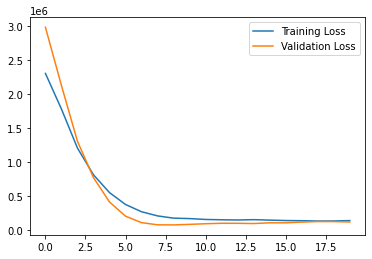

In [39]:
tl, = plt.plot(hist1.history['loss'])
vl, = plt.plot(hist1.history['val_loss'])
plt.legend([tl, vl], ["Training Loss", "Validation Loss"])

In [51]:
eval_nth_set(hist1, 5)

Validation MSE = 204352.75


## Train/Test Set Number 2

In [41]:
model2, hist2 = train_nth_set(input_data, n = 2, epochs = 20)

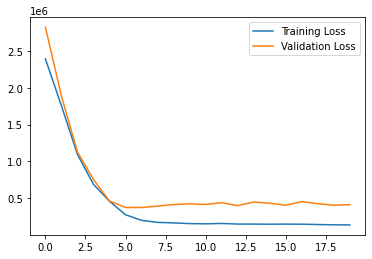

In [42]:
tl, = plt.plot(hist2.history['loss'])
vl, = plt.plot(hist2.history['val_loss'])
plt.legend([tl, vl], ["Training Loss", "Validation Loss"])

In [54]:
eval_nth_set(hist2, 5)

Validation MSE = 372550.34375


## Train/Test Set Number 3

In [58]:
model3, hist3 = train_nth_set(input_data, n = 3, epochs = 20)

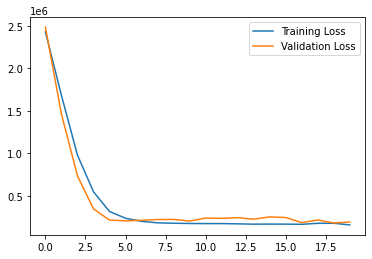

In [59]:
tl, = plt.plot(hist3.history['loss'])
vl, = plt.plot(hist3.history['val_loss'])
plt.legend([tl, vl], ["Training Loss", "Validation Loss"])

In [64]:
eval_nth_set(hist3, 5)

Validation MSE = 206873.359375


## Testing

After hyperparameters tuning, feature selection and cross validation, since the third model has the best performance, we will use the third model as our final model.

In [65]:
fmodel, _ = train_nth_set(input_data, n = 3, epochs = 5)
fmodel.evaluate(tf.convert_to_tensor(X_dev[4-1].reshape((-1, len(X_train[4-1][0]), 1)), np.float32), 
               tf.convert_to_tensor(y_dev[4-1].reshape((-1, 1, 1)), np.float32))

1/1 [==============================] - 1s 514ms/step - loss: 124422.4141 - mean_absolute_percentage_error: 24.9363 - mean_absolute_error: 278.5890


[124422.4140625, 24.936250686645508, 278.5889587402344]

The percentage error is 24.9%, which indicates that we should allow around 25% of buffer bike count.

In [67]:
fmodel.save("./final_lstm")

INFO:tensorflow:Assets written to: ./final_lstm\assets


INFO:tensorflow:Assets written to: ./final_lstm\assets


## 7-days Prediction for Demonstration

In [ ]:
fmodel = keras.models.load_model("./final_lstm")

In [103]:
demo0 = pd.read_csv('../data/7days_demo.csv')
demo0.head()
demo = demo0.copy()

In [104]:
demo.drop(['solar_radiation'], axis = 1, inplace = True)
demo.drop(['temperature'], axis = 1, inplace = True)
demo.drop(['wind_speed'], axis = 1, inplace = True)

In [105]:
demo.drop(['Unnamed: 0', 'date', 'rep_count'], axis = 1, inplace = True)
demo1 = pd.get_dummies(demo, columns=['season', 'holiday'])
demo1.head()

,snowfall,rainfall,rent_count,humidity,visibility,dewpoint_temp,season_Autumn,holiday_No Holiday
0,787,10.9,6477,84.5,10460,0.00,1,1
1,414,0.0,11212,81.5,4295,0.75,1,1
2,29,0.0,17162,70.5,4675,1.00,1,1
3,0,0.0,16282,73.0,3725,1.35,1,1
4,0,0.0,16524,26.0,14640,-12.95,1,1


In [106]:
demo1['season_Spring'] = np.zeros(7, dtype = np.int8)
demo1['season_Summer'] = np.zeros(7, dtype = np.int8)
demo1['season_Winter'] = np.zeros(7, dtype = np.int8)
demo1['holiday_Holiday'] = np.zeros(7, dtype = np.int8)

In [107]:
cols = demo1.columns.to_list()[:7] + demo1.columns.to_list()[8:] + ['holiday_No Holiday']
demo2 = demo1[cols]
demo2.head()

,snowfall,rainfall,rent_count,humidity,visibility,dewpoint_temp,season_Autumn,season_Spring,season_Summer,season_Winter,holiday_Holiday,holiday_No Holiday
0,787,10.9,6477,84.5,10460,0.00,1,0,0,0,0,1
1,414,0.0,11212,81.5,4295,0.75,1,0,0,0,0,1
2,29,0.0,17162,70.5,4675,1.00,1,0,0,0,0,1
3,0,0.0,16282,73.0,3725,1.35,1,0,0,0,0,1
4,0,0.0,16524,26.0,14640,-12.95,1,0,0,0,0,1


In [109]:
preds = fmodel.predict(tf.convert_to_tensor(demo2.to_numpy().reshape((-1, 12, 1)), np.float32))

In [113]:
demo0['predicted_rep_count'] = preds
demo0.to_csv('../data/7days_demo.csv')